In [259]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

UsageError: Line magic function `%` not found.


In [260]:
# read in the json files
portfolio = pd.read_json('../input/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../input/profile.json', orient='records', lines=True)
transcript = pd.read_json('../input/transcript.json', orient='records', lines=True)

In [261]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [262]:
portfolio = portfolio.rename(columns={'id': 'offer_id', 
                                      'difficulty': 'required_spend',
                                     })

In [263]:
dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)
portfolio = portfolio.merge(dummies, left_index=True, right_index=True)
portfolio = portfolio.drop('channels', axis=1)

In [264]:
portfolio['offer_name'] = portfolio['offer_type'] + '_' + portfolio['required_spend'].astype(str) + '$_' + portfolio['duration'].astype(str) + 'days'

In [ ]:
portfolio

In [265]:
portfolio.duplicated().sum()

0

In [ ]:
profile.head(5)

In [266]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['became_member_year'] = pd.DatetimeIndex(profile['became_member_on']).year
profile['became_member_month'] = pd.DatetimeIndex(profile['became_member_on']).month

In [267]:
profile['membership_duration'] = (profile['became_member_on'].max() - profile['became_member_on'])

In [268]:
profile.head(5)

,gender,age,id,became_member_on,income,became_member_year,became_member_month,membership_duration
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,529 days
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,376 days
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,14 days
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,443 days
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,356 days


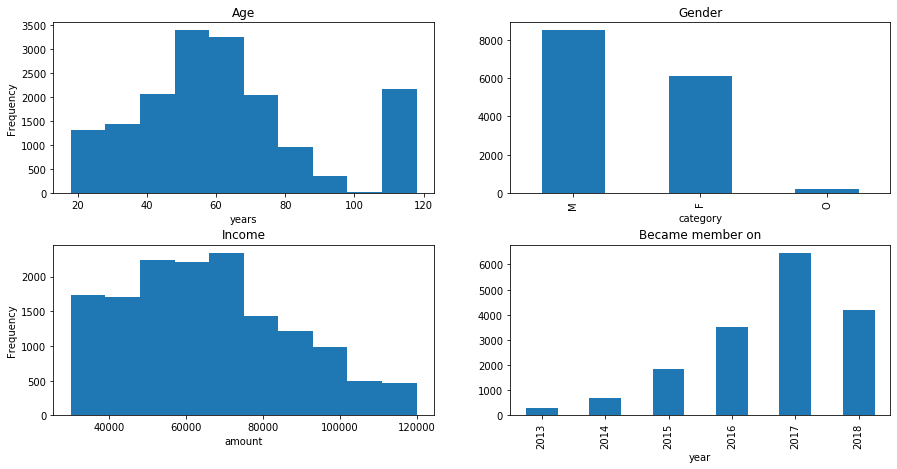

In [269]:
fig, axes = plt.subplots(2, 2, figsize=(15,7))

profile['age'].plot(kind='hist', ax=axes[0, 0], title='Age').set_xlabel('years')
profile['gender'].value_counts().plot(kind='bar', ax=axes[0, 1], title='Gender').set_xlabel('category')
profile['income'].plot(kind='hist', ax=axes[1, 0], title='Income').set_xlabel('amount')
profile['became_member_year'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], title='Became member on').set_xlabel('year')

plt.subplots_adjust(hspace = 0.3, bottom=0.1)
plt.show()

In [270]:
profile['age'] = profile['age'].replace(118, np.nan)

In [271]:
# Dropping O to maintain the balance in the dataset for further prediction
profile['gender'] = profile[profile['gender'] !='O']

In [272]:
profile['gender'].value_counts()

M    8484
F    6129
Name: gender, dtype: int64

In [273]:
profile['gender'] = profile['gender'].map({'M': 0, 'F': 1})

In [274]:
profile['gender'].value_counts()

0.0    8484
1.0    6129
Name: gender, dtype: int64

In [275]:
profile.duplicated().sum()

0

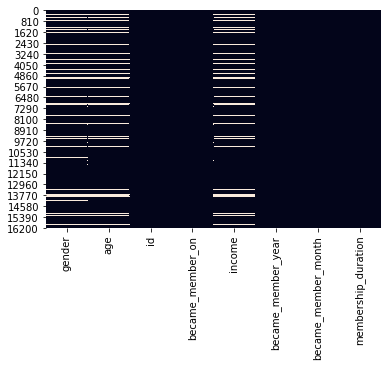

In [276]:
sns.heatmap(profile.isnull(), cbar=False)

In [277]:
profile = profile.drop(profile[profile['age'].isnull()].index)

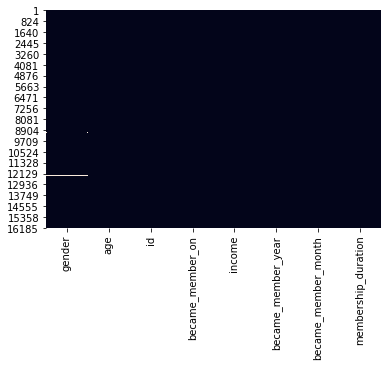

In [278]:
sns.heatmap(profile.isnull(), cbar=False)

In [279]:
# grouping ages into groups to combine them into categories
# binning of age -> transform into descrete groups
bins = [10, 20, 30, 40, 50, 60, 70, 80, 120]
group_names = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
profile['age_categories'] = pd.cut(profile['age'], bins, labels=group_names)

In [280]:
bins = [20000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000]
labels = ['20k-39k', '40k-49k', '50k-59k', '60k-69k', '70k-79k', '80k-89k', '90k-99k', '100k-109k', '110k-120k']
profile['income_binned'] = pd.cut(profile['income'], bins=bins, labels=labels)

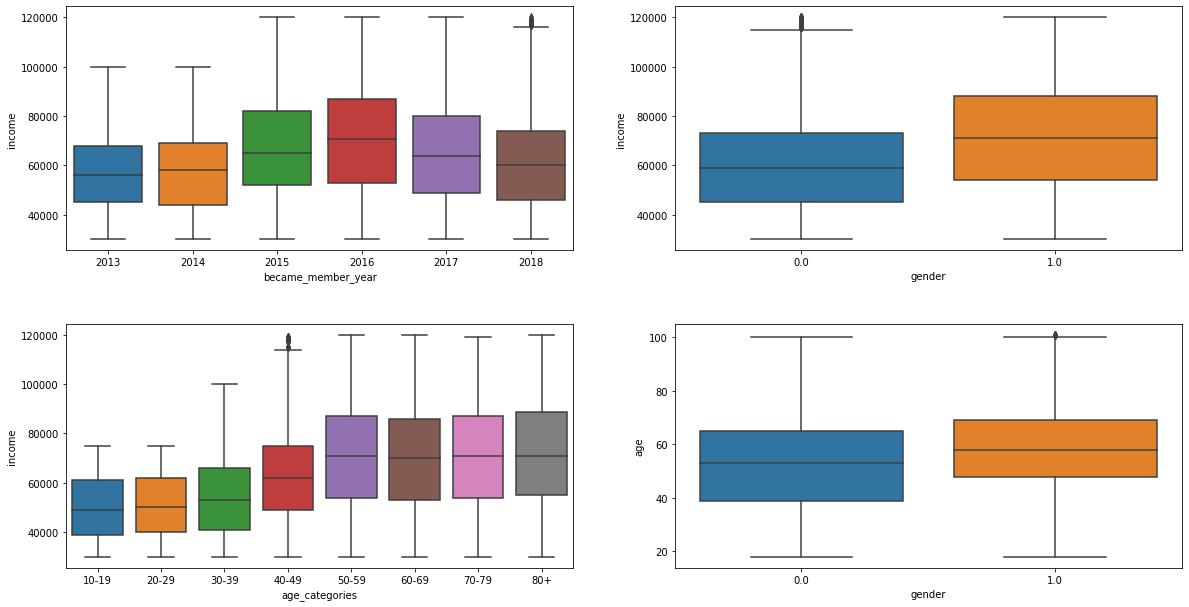

In [281]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.boxplot(data=profile, x='became_member_year', y='income', ax=axes[0, 0])
sns.boxplot(data=profile, x='gender', y='income', ax=axes[0, 1])
sns.boxplot(data=profile, x='age_categories', y='income', ax=axes[1, 0])
sns.boxplot(data=profile, x='gender', y='age', ax=axes[1, 1])
plt.subplots_adjust(hspace = 0.3, bottom=0.1)

In [282]:
profile = profile.rename(columns={'id': 'customer_id'})

In [283]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [284]:
# getting the values out of a dict object
# combining both offer id and offer_id into a single column
values_df = pd.DataFrame(transcript['value'].tolist())
values_df['offerid'] = values_df['offer id'].combine_first(values_df['offer_id'])
values_df.drop(['offer id', 'offer_id'], axis=1, inplace=True)
index_df = pd.DataFrame({'idx': transcript.index.values.tolist()})
combined = index_df.merge(values_df, left_index=True, right_index=True)
combined_index = combined.set_index('idx')
transcript = transcript.merge(combined_index, left_index=True, right_index=True)

In [285]:
transcript.head(5)

,person,event,value,time,amount,reward,offerid
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [286]:
transcript = transcript.merge(portfolio, left_on='offerid', right_on='offer_id', how='left')

In [287]:
transcript = transcript.rename(columns={'reward_x': 'paid_reward', 
                                        'reward_y': 'planned_reward', 
                                       })

In [288]:
transcript = transcript.rename(columns={'person': 'customer_id'})

In [289]:
transcript['time'] = transcript['time'] / 24

In [290]:
transcript = transcript.drop(columns=['value'])

In [291]:
print(transcript.duplicated().sum())

397


In [292]:
transcript = transcript.drop_duplicates().reset_index(drop=True)

In [293]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

In [294]:
transaction_df = transcript[transcript['event'] == 'transaction'].copy()
transaction_df = transaction_df[['customer_id', 'time', 'amount']]
transaction_df.head(5)

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [295]:
offer_df = transcript[transcript['event'] != 'transaction'].copy()
offer_df = pd.get_dummies(offer_df, columns=['event'], prefix=None)
offer_df = offer_df.drop(columns=['amount', 'offerid', 'paid_reward'], axis=1)

In [296]:
offer_df = offer_df.rename(columns={'event_offer completed': 'event_offer_completed',
                                   'event_offer received': 'event_offer_received',
                                    'event_offer viewed': 'event_offer_viewed'
                                   })

In [297]:
offer_df.head(5)

,customer_id,time,planned_reward,required_spend,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_name,event_offer_completed,event_offer_received,event_offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,bogo_5$_7days,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0.0,5.0,20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0,discount_20$_10days,0,1,0
2,e2127556f4f64592b11af22de27a7932,0.0,2.0,10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,discount_10$_7days,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,2.0,10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,discount_10$_10days,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0.0,10.0,10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,bogo_10$_5days,0,1,0


In [298]:
count_events = transcript['event'].value_counts()
total_events = count_events.sum()
percentage_transactions = count_events[0] / total_events * 100
percentage_offers = count_events[1:].sum() / total_events * 100

percentage_transactions, percentage_offers, count_events

(45.38915583545929, 54.610844164540715, transaction        138953
 offer received      76277
 offer viewed        57725
 offer completed     33182
 Name: event, dtype: int64)

In [ ]:
print(portfolio.columns.to_list())
portfolio.head(1)

In [ ]:
print(transaction_df.columns.to_list())
transaction_df.head(1)

In [ ]:
print(offer_df.columns.to_list())
offer_df.head(1)

In [ ]:
print(profile.columns.to_list())
profile.head(1)

In [ ]:
# window function
# get customer ids from offers_df -> [customerid, customerid]
    # get first customerid
    # get customer profile data based on the customerid -> customer
    # get all offers associated with the customerid from offer_df -> customer_offer_data
    # get all transactions associated with the customerid from transaction_df -> customer_transaction_data
    # get received, viewed, completed from customer_offer_data from offer_df -> offer_received, offer_viewed, offer_completed
        # loop through each received offer from offer_received
        # get the offerid
        # get the offer row from portfolio
        # extract duration days from offer row
        # initialize start and end of an offer
        # get offers completed within end date
        # get offers viewed within end date
        # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
        # flag offer_successful_wo_view to 1 if an offer is not viewed and completed within end time else to 0
        # get transactions occured within offer end time
        # calculate total amount spent by a customer within offer end time
        


In [299]:
offer_df['offer_valid'] = offer_df.apply(lambda x: x['time'] + x['duration'], axis=1).where(offer_df['event_offer_received'] == 1, np.nan)

In [305]:
offer_df[offer_df['event_offer_completed'] == 1].head(5)

,customer_id,time,planned_reward,required_spend,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_name,event_offer_completed,event_offer_received,event_offer_viewed,offer_valid
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,2.0,10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,discount_10$_7days,1,0,0,NaN
12672,fe97aa22dd3e48c8b143116a8403dd52,0.0,2.0,10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,discount_10$_10days,1,0,0,NaN
12679,629fc02d56414d91bca360decdfa9288,0.0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,bogo_5$_7days,1,0,0,NaN
12692,676506bad68e4161b9bbaffeb039626b,0.0,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,bogo_10$_7days,1,0,0,NaN
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.0,10.0,10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,bogo_10$_5days,1,0,0,NaN


In [366]:
def offer_validity_check(df):
    df['received'] = df[df['event_offer_received'] == 1]['time'].where(df['event_offer_received'] == 1, np.nan)
    df['viewed'] = df[df['event_offer_viewed'] == 1]['time'].where(df['event_offer_viewed'] == 1, np.nan)
    df['completed'] = df[df['event_offer_completed'] == 1]['time'].where(df['event_offer_completed'] == 1, np.nan)
    df['offer_valid'] = df[df['event_offer_received'] == 1]['offer_valid'].where(df['event_offer_received'] == 1, np.nan)
    df = df.ffill().bfill()
    
    valid = (df['event_offer_viewed'] > 0) & (df['received'] <= df['completed']) & (df['completed'] <= df['offer_valid']) 
    df['offer_within_time'] = valid
    return df


In [367]:
test = offer_df.copy()
test = test.iloc[:15000, :].groupby(['customer_id', 'offer_id'], as_index=False).apply(offer_validity_check)

In [373]:
test[test['offer_within_time'] == True].head(10)

,customer_id,time,planned_reward,required_spend,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_name,event_offer_completed,event_offer_received,event_offer_viewed,offer_valid,received,viewed,completed,offer_within_time
12652,102e9454054946fda62242d2e176fdce,0.0,10.0,10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,bogo_10$_5days,0,0,1,5.0,0.0,0.0,0.25,True
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,2.0,10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,discount_10$_7days,0,0,1,7.0,0.0,0.0,0.00,True
12677,629fc02d56414d91bca360decdfa9288,0.0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,bogo_5$_7days,0,0,1,7.0,0.0,0.0,0.00,True
12688,62fb072537a647a89f99fb9ea66a7c00,0.0,2.0,10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,discount_10$_10days,0,0,1,10.0,0.0,0.0,0.25,True
12690,676506bad68e4161b9bbaffeb039626b,0.0,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,bogo_10$_7days,0,0,1,7.0,0.0,0.0,0.00,True
12695,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.0,10.0,10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,bogo_10$_5days,0,0,1,5.0,0.0,0.0,0.00,True
12715,227f2d69e46a4899b70d48182822cff6,0.0,10.0,10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,bogo_10$_5days,0,0,1,5.0,0.0,0.0,0.00,True
12730,580282318a424572b41b1ad3516eb976,0.0,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,bogo_10$_7days,0,0,1,7.0,0.0,0.0,0.25,True
12742,d72d201be5794279aa716d8ad82b8d90,0.0,5.0,5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,bogo_5$_5days,0,0,1,5.0,0.0,0.0,0.00,True
12755,9ab83b0a9fe74e4ead33c741bcc4c2ea,0.0,2.0,10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,discount_10$_10days,0,0,1,10.0,0.0,0.0,0.25,True


In [374]:
test[test['customer_id'] == '580282318a424572b41b1ad3516eb976']

,customer_id,time,planned_reward,required_spend,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_name,event_offer_completed,event_offer_received,event_offer_viewed,offer_valid,received,viewed,completed,offer_within_time
350,580282318a424572b41b1ad3516eb976,0.00,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,bogo_10$_7days,0,1,0,7.0,0.0,0.0,0.25,False
12730,580282318a424572b41b1ad3516eb976,0.00,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,bogo_10$_7days,0,0,1,7.0,0.0,0.0,0.25,True
15630,580282318a424572b41b1ad3516eb976,0.25,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,bogo_10$_7days,1,0,0,7.0,0.0,0.0,0.25,False


In [371]:
offer_df[offer_df['event_offer_received'] == 1].head(5)

,customer_id,time,planned_reward,required_spend,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_name,event_offer_completed,event_offer_received,event_offer_viewed,offer_valid
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,bogo_5$_7days,0,1,0,7.0
1,a03223e636434f42ac4c3df47e8bac43,0.0,5.0,20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0,discount_20$_10days,0,1,0,10.0
2,e2127556f4f64592b11af22de27a7932,0.0,2.0,10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,discount_10$_7days,0,1,0,7.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,2.0,10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,discount_10$_10days,0,1,0,10.0
4,68617ca6246f4fbc85e91a2a49552598,0.0,10.0,10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,bogo_10$_5days,0,1,0,5.0
